# Predictive Models 101: Model Evaluation

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 17 | Notebook 2 of 3**

This notebook covers cross-validation, model complexity, and evaluation metrics
using gradient boosting for customer profitability prediction.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

---

## 1. Intuition {#intuition}

### The Cross-Validation Imperative

ML models can be made arbitrarily powerful. A sufficiently complex model will
**perfectly fit** the training data. But this is dangerous:

1. Perfect fit on training ≠ good predictions on new data
2. Complex models learn **noise** in addition to **signal**
3. This is called **overfitting**

**Solution**: Cross-validation - hide part of the data during training,
then evaluate on the hidden portion.

> "In God we trust; all others must bring data." - W. Edwards Deming

### Model Complexity Spectrum

| Model | Complexity | Risk |
|-------|-----------|------|
| Mean | None | High bias (underfitting) |
| Linear | Low | Moderate bias |
| Shallow tree | Medium | Balanced |
| Deep forest | High | High variance (overfitting) |

The goal is to find the **sweet spot** - complex enough to capture patterns,
simple enough to generalize.

---

## 2. Formal Treatment {#formal}

### 2.1 Cross-Validation

**Train-Test Split**:
1. Partition data: $D = D_{train} \cup D_{test}$
2. Train model on $D_{train}$: $\hat{f} = \text{Train}(D_{train})$
3. Evaluate on $D_{test}$: $\text{Error} = \text{Loss}(D_{test}, \hat{f})$

**K-Fold Cross-Validation**:
1. Split data into K folds: $D = D_1 \cup D_2 \cup ... \cup D_K$
2. For each fold $k$:
   - Train on $D \setminus D_k$
   - Evaluate on $D_k$
3. Average errors across folds

K-fold provides more robust error estimates than single train-test split.

### 2.2 Evaluation Metrics for Regression

**R-squared** ($R^2$):
$$R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2} = 1 - \frac{SS_{res}}{SS_{tot}}$$

Interpretation:
- $R^2 = 1$: Perfect prediction
- $R^2 = 0$: Predicting the mean
- $R^2 < 0$: Worse than predicting the mean

**Mean Squared Error** (MSE):
$$MSE = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$$

**Root MSE** (RMSE): $\sqrt{MSE}$ - same units as outcome

**Mean Absolute Error** (MAE):
$$MAE = \frac{1}{n} \sum_i |y_i - \hat{y}_i|$$

### 2.3 Gradient Boosting

Gradient boosting builds an **ensemble** of weak learners (usually trees) sequentially:

$$\hat{f}(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$$

At each step $m$:
1. Compute residuals: $r_i = y_i - \hat{f}_{m-1}(x_i)$
2. Fit a new tree $h_m$ to residuals
3. Update: $\hat{f}_m = \hat{f}_{m-1} + \gamma_m h_m$

**Key hyperparameters**:
- `n_estimators`: Number of trees (M)
- `max_depth`: Tree depth (complexity)
- `learning_rate`: Step size ($\gamma$)
- `min_samples_split`: Regularization

---

## 3. Numeric Demonstration {#numeric}

### Load and Prepare Data

In [2]:
# Load data
transactions = load_facure_data("customer_transactions.csv")
profitable = transactions[['customer_id']].assign(
    net_value=transactions.drop(columns='customer_id').sum(axis=1)
)
customer_features = load_facure_data("customer_features.csv").merge(
    profitable, on='customer_id'
)

# Train-test split
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)

print(f"Training: {len(train)}, Test: {len(test)}")

Training: 7000, Test: 3000


In [3]:
# Feature engineering: encode region with target mean
region_means = train.groupby('region')['net_value'].mean().to_dict()

def encode_region(df, region_means):
    """Replace region with its average net_value from training set."""
    return df.assign(region_encoded=df['region'].map(region_means).fillna(0))

train_enc = encode_region(train, region_means)
test_enc = encode_region(test, region_means)

features = ['region_encoded', 'income', 'age']
target = 'net_value'

### Demonstrating Overfitting

In [4]:
# Compare different model complexities
depth_range = [1, 2, 4, 8, 12, 16]
results = []

for depth in depth_range:
    model = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=depth,
        learning_rate=0.1,
        min_samples_split=10,
        random_state=42
    )
    model.fit(train_enc[features], train_enc[target])
    
    train_r2 = r2_score(train_enc[target], model.predict(train_enc[features]))
    test_r2 = r2_score(test_enc[target], model.predict(test_enc[features]))
    
    results.append({
        'max_depth': depth,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'gap': train_r2 - test_r2
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 max_depth  train_r2  test_r2    gap
         1    0.6946   0.6932 0.0014
         2    0.6997   0.6950 0.0046
         4    0.7289   0.6923 0.0366
         8    0.8336   0.6654 0.1683
        12    0.9284   0.6332 0.2952
        16    0.9728   0.6104 0.3623


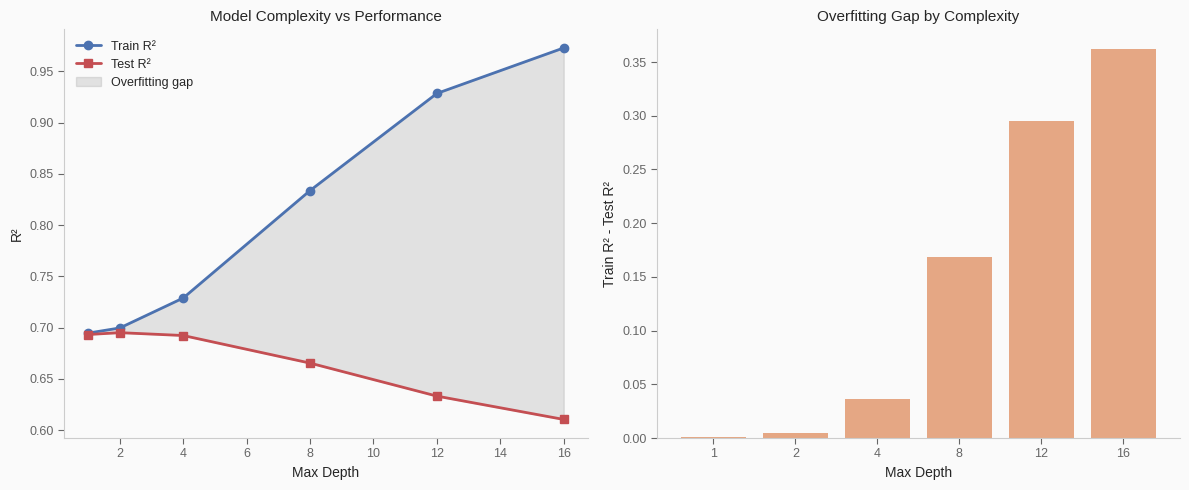


Best max_depth: 2
Test R²: 0.6950


In [5]:
# Visualize overfitting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: R² by depth
ax = axes[0]
ax.plot(results_df['max_depth'], results_df['train_r2'], 'o-', 
        color=COLORS['blue'], label='Train R²', linewidth=2)
ax.plot(results_df['max_depth'], results_df['test_r2'], 's-', 
        color=COLORS['red'], label='Test R²', linewidth=2)
ax.fill_between(results_df['max_depth'], results_df['test_r2'], results_df['train_r2'],
                alpha=0.2, color='gray', label='Overfitting gap')
ax.set_xlabel('Max Depth')
ax.set_ylabel('R²')
ax.set_title('Model Complexity vs Performance')
ax.legend()
apply_tufte_style(ax)

# Right: Overfitting gap
ax = axes[1]
ax.bar(results_df['max_depth'].astype(str), results_df['gap'], 
       color=COLORS['orange'], alpha=0.7)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Train R² - Test R²')
ax.set_title('Overfitting Gap by Complexity')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# Best depth
best_idx = results_df['test_r2'].idxmax()
print(f"\nBest max_depth: {results_df.loc[best_idx, 'max_depth']}")
print(f"Test R²: {results_df.loc[best_idx, 'test_r2']:.4f}")

### Training the Final Model

In [6]:
# Train final model with tuned parameters
model = GradientBoostingRegressor(
    n_estimators=400,
    max_depth=4,
    min_samples_split=10,
    learning_rate=0.01,
    random_state=123
)

model.fit(train_enc[features], train_enc[target])

# Evaluate
train_pred = model.predict(train_enc[features])
test_pred = model.predict(test_enc[features])

print("Model Performance:")
print(f"  Train R²: {r2_score(train_enc[target], train_pred):.4f}")
print(f"  Test R²:  {r2_score(test_enc[target], test_pred):.4f}")
print(f"  Train RMSE: {np.sqrt(mean_squared_error(train_enc[target], train_pred)):.2f}")
print(f"  Test RMSE:  {np.sqrt(mean_squared_error(test_enc[target], test_pred)):.2f}")

Model Performance:
  Train R²: 0.7109
  Test R²:  0.6939
  Train RMSE: 59.91
  Test RMSE:  63.47


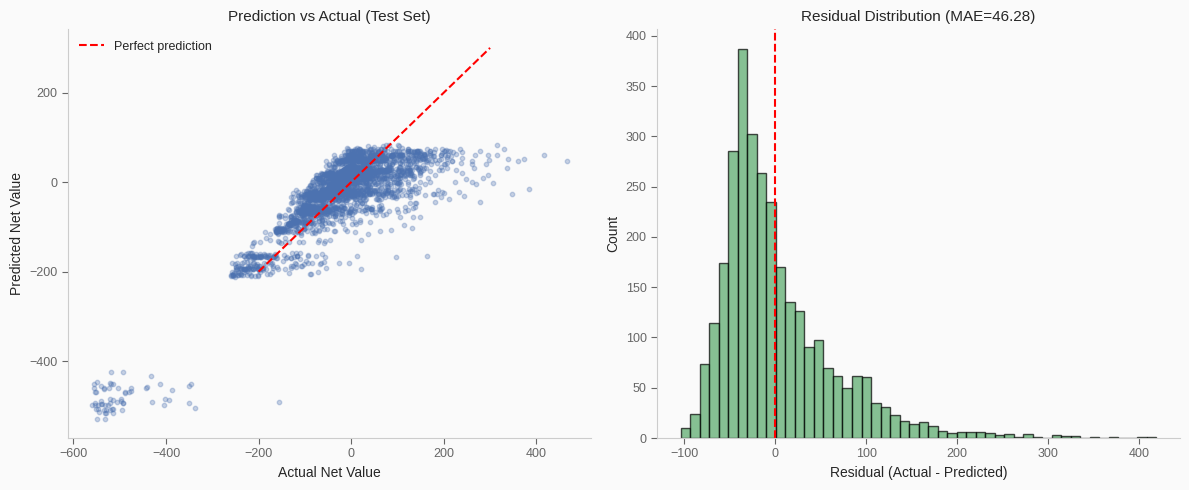

In [7]:
# Prediction vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax = axes[0]
ax.scatter(test_enc[target], test_pred, alpha=0.3, s=10, color=COLORS['blue'])
ax.plot([-200, 300], [-200, 300], 'r--', label='Perfect prediction')
ax.set_xlabel('Actual Net Value')
ax.set_ylabel('Predicted Net Value')
ax.set_title('Prediction vs Actual (Test Set)')
ax.legend()
apply_tufte_style(ax)

# Residual distribution
ax = axes[1]
residuals = test_enc[target].values - test_pred
ax.hist(residuals, bins=50, color=COLORS['green'], alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Count')
ax.set_title(f'Residual Distribution (MAE={np.mean(np.abs(residuals)):.2f})')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

---

## 4. Implementation {#implementation}

### Feature Importance

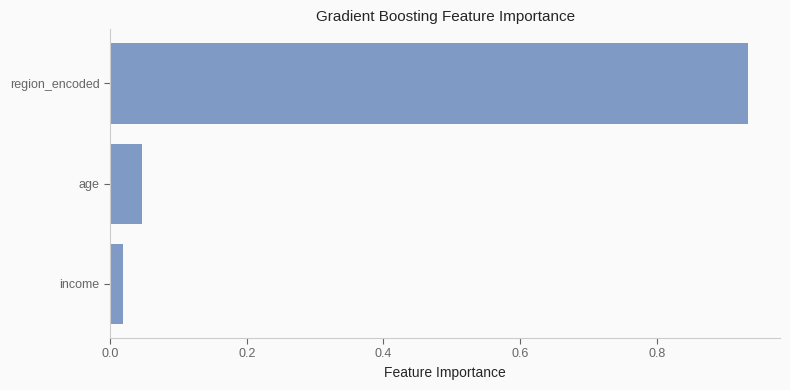

       feature  importance
        income      0.0191
           age      0.0470
region_encoded      0.9339


In [8]:
# Feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(importance['feature'], importance['importance'], color=COLORS['blue'], alpha=0.7)
ax.set_xlabel('Feature Importance')
ax.set_title('Gradient Boosting Feature Importance')
apply_tufte_style(ax)
plt.tight_layout()
plt.show()

print(importance.to_string(index=False))

### K-Fold Cross-Validation

In [9]:
# 5-fold cross-validation on training set
cv_scores = cross_val_score(
    GradientBoostingRegressor(
        n_estimators=400,
        max_depth=4,
        min_samples_split=10,
        learning_rate=0.01,
        random_state=123
    ),
    train_enc[features],
    train_enc[target],
    cv=5,
    scoring='r2'
)

print(f"5-Fold Cross-Validation R²:")
print(f"  Scores: {cv_scores}")
print(f"  Mean: {cv_scores.mean():.4f}")
print(f"  Std: {cv_scores.std():.4f}")

5-Fold Cross-Validation R²:
  Scores: [0.66789551 0.69578927 0.63770069 0.70746919 0.71243694]
  Mean: 0.6843
  Std: 0.0279


```
★ Insight ─────────────────────────────────────────────────────
Cross-validation R² is typically lower than test set R² because:
1. Each fold uses less training data
2. It provides more robust error estimates
3. Multiple runs reduce luck factor

Use CV for model selection, final test set for reporting.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: What is overfitting and how do you detect it?

<details>
<summary>Solution</summary>

**Overfitting**: Model learns noise in training data, performs poorly on new data.

**Detection**:
- Train performance >> Test performance (large gap)
- Performance degrades as model complexity increases
- Very high training accuracy (approaching 100%)

**Prevention**:
- Regularization (L1/L2 penalties, dropout)
- Early stopping
- Reduce model complexity
- More training data
- Cross-validation for hyperparameter tuning

</details>

### Q2: Explain R² and when it can be negative.

<details>
<summary>Solution</summary>

**R² formula**: $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

**Interpretation**:
- $R^2 = 1$: Perfect prediction (residuals = 0)
- $R^2 = 0$: Model predicts the mean
- $R^2 < 0$: Model worse than predicting the mean

**When R² is negative**:
- Model is very wrong (predictions far from actual)
- Usually indicates severe overfitting or wrong model
- Often seen when evaluating on test set a model that overfit training

**Note**: R² computed on training set is always ≥ 0 (intercept term).

</details>

### Q3: How does gradient boosting differ from random forest?

<details>
<summary>Solution</summary>

| Aspect | Gradient Boosting | Random Forest |
|--------|------------------|---------------|
| Training | Sequential (trees on residuals) | Parallel (independent trees) |
| Bias-Variance | Reduces bias | Reduces variance |
| Overfitting | More prone | More robust |
| Speed | Slower (sequential) | Faster (parallelizable) |
| Tuning | More sensitive | Easier to tune |
| Performance | Often higher ceiling | More reliable baseline |

**When to use which**:
- GB: Maximum performance, willing to tune carefully
- RF: Quick baseline, robust out-of-box, parallel compute

</details>

---

## 6. References {#references}

[^1]: Friedman, J. H. (2001). Greedy Function Approximation: A Gradient Boosting Machine.
      *Annals of Statistics*, 29(5), 1189-1232.

[^2]: Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 17.